In [79]:
from typing import Tuple, Dict

import h5py
import pandas as pd
import numpy as np
from joblib import load, dump
from umap import UMAP
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV 
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("publication")

In [2]:
def standardize_test(estimator: "sklearn model", search_params: Tuple[Dict], data: Tuple[np.ndarray, np.ndarray]):
    # split data into X and y for regression
    X, y = data
    # Manually specify 10-fold cross-validation for the grid search
    kfold = KFold(10, random_state=42, shuffle=True)
    grid_search = GridSearchCV(
        estimator, search_params, scoring="neg_mean_squared_error", cv=kfold, n_jobs=4
    )
    # run the grid search
    grid_search.fit(X, y)
    # give some summary statistics
    y_mask = y != 0.
    y_pred = grid_search.best_estimator_.predict(X)
    mse = metrics.mean_squared_error(y_pred, y)
    masked_mse = metrics.mean_squared_error(y_pred[y_mask], y[y_mask])
    print(f"Best MSE: {mse:.4f}")
    print(f"Best masked MSE: {masked_mse:.4f}")
    return grid_search, grid_search.best_estimator_

## Setting molecules with no chance of observing to zero column

In [3]:
data = h5py.File("../../data/processed/smiles_embeddings_300.h5", "r")

In [4]:
data.keys()

<KeysViewHDF5 ['cluster_ids', 'pca', 'smiles', 'vectors']>

In [5]:
pipeline = load("../../models/embedding_pipeline.pkl")
pca = load("../../models/pca_model.pkl")

In [6]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

# tmc1_df = tmc1_df.loc[tmc1_df["Formula"] != "H2"]

tmc1_df.reset_index(inplace=True, drop=True)

In [7]:
tmc1_vecs = np.vstack(tmc1_df["Vecs"])

In [8]:
# Here we purposefully withdraw some classes of molecules to see
# how well these are reproduced
holdout_df = tmc1_df.loc[~tmc1_df["Formula"].isin(["HC5N", "HC9N", "CH3C4H"])]

In [9]:
holdout_df

,Molecule,Formula,SMILES,Column density (cm^-2),DOI,Isotopologue,Upper Limit,Notes,Vecs
0,Methyltriacetylene,CH3C6H,C#CC#CC#CC,3.100000e+12,10.1086/504918,0,0,Remijan,"[2.0953827, -4.50535, 0.52709067, -1.2093838, ..."
2,Methylcyanodiacetylene,CH3C5N,CC#CC#CC#N,8.400000e+11,10.1086/504918,0,0,Remijan,"[1.207319, -5.1080704, -0.039868705, -1.834622..."
3,Methylcyanoacetylene,CH3C3N,CC#CC#N,1.800000e+12,10.1086/504918,0,0,Remijan,"[1.1559796, -3.068057, -0.3394103, -1.3995979,..."
4,Protonated nitrogen,N2H+,N#[NH+],5.000000e+12,10.3847/1538-4365/aa69ba,0,0,"FCRAO, 1 - 0; towards CP","[0.11407158, -0.76171607, -0.95510256, -0.7127..."
5,Ammonia,NH3,N,5.010000e+14,10.3847/0067-0049/225/2/25,0,0,Kaifu survey obs,"[-0.09987478, -0.032913096, -0.81312376, -0.03..."
...,...,...,...,...,...,...,...,...,...
79,Protonated cyanogen,NCCNH+,N#CC#[NH+],8.600000e+10,10.1051/0004-6361/201526650,0,0,Yebes,"[0.35317123, -3.2156177, -2.2517192, -2.456177..."
80,NaN,C6H2,C=C=C=C=C=C,2.130000e+10,10.1086/310622,0,0,NASA DSN 70m; converted assuming H2 density,"[1.2601768, -4.890073, -1.674466, -1.8292549, ..."
81,Propylene,CH3CHCH2,C=CC,4.000000e+13,10.1086/521398,0,0,IRAM 30m,"[1.0377933, 0.99821156, -0.22186852, -1.248241..."
82,Cyanoallene,CH2C2HCN,C=C=CC#N,4.500000e+11,10.1086/500431,0,0,GBT 100m,"[1.6163945, -3.59433, -0.6654961, -1.8897333, ..."


In [10]:
holdout_vecs = np.vstack(holdout_df["Vecs"])

In [11]:
pipeline

Pipeline(steps=[('incrementalpca', IncrementalPCA(n_components=100)),
                ('kmeans', KMeans(n_clusters=20, random_state=42))])

In [12]:
tmc1_cluster_ids = pipeline.predict(tmc1_vecs).compute()
holdout_cluster_ids = pipeline.predict(holdout_vecs).compute()

In [13]:
tmc1_embedding = pipeline.steps[0][1].transform(tmc1_vecs)
holdout_embedding = pipeline.steps[0][1].transform(holdout_vecs)

In [14]:
holdout_y = np.log10(holdout_df["Column density (cm^-2)"].to_numpy())

## Prepping data

In [15]:
indices = np.arange(len(data["pca"]))

rng = np.random.default_rng(42)

mask = np.zeros_like(data["cluster_ids"], dtype=bool)
for i in np.unique(tmc1_cluster_ids):
    mask += data["cluster_ids"][:] == i

In [16]:
# Extract out the molecules contained within our cluster
all_pca = (data["pca"][:])[mask,:]
subset_smiles = (data["smiles"][:])[mask]

In [17]:
X = tmc1_embedding
Y = tmc1_df["Column density (cm^-2)"].to_numpy()
Y = np.log10(Y)
shift = Y.mean()
# Y -= shift

In [18]:
# calculate pairwise distances between TMC-1 molecules and all others
distances = cosine_distances(tmc1_embedding, all_pca)

In [19]:
dist_mask = distances.mean(axis=0) > 0.88

In [20]:
# this counts the number of molecules we're artificially constraining
dist_mask.sum()

199

### What molecules are we setting to zero?

You can expand the cell below to see SMILES for the molecules we're zeroing

In [21]:
subset_smiles[dist_mask]

array(['CCCCCCCCNS(=O)(=O)CCNC1CCCCC1',
       'CCCN1N=C(N=C1C1=NON=C1N)C1=NON=C1N',
       'CC(=O)NC(C(O)C(F)C(=O)C(=O)O)C(O)C(O)C(O)CO',
       'C1=CC2C=CC3C=CC[N-]C=3C=2[N-]C1.CC[Sn](F)(F)CC',
       'CC(CCNCCNCCC(C)CC(C)(C)C)CC(C)(C)C',
       'O=C(CO)C(O)C(O)C(O)CO.O=CC(O)C(O)C(O)C(O)CO',
       'CC1CC(C)(C)N(N=1)C1N=C(N)N=C(CN2C=CN=C2)N=1',
       'O=C(O)CC(O)(CC(=O)O)C(=O)O.OCCCNCCCO',
       'OCC(O)C(O)C(O)C(O)CNCC(O)C(O)C(O)C(O)CO',
       'CCN1C(C)=NC2NC3=C(C(=O)C=21)C(=O)N(C)C(=O)N3C',
       'CC(=CCO)CCC=C(C)CCC=C(C)CCC1OC1(C)C',
       'CC(C)N(CCSSCCN(C(C)C)C(C)C)C(C)C',
       'O=C([O-])[O-].[Al+3].[Al+3].[Mg+2].[Mg+2].[Mg+2].[Mg+2].[Mg+2].[Mg+2].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-].[OH-]',
       'C=CC(CO)N1CC1CC(C)C.C=CC(O)CN1CC1CC(C)C',
       'O=C(O)CN1C(=O)SC(C1=O)=C1C(=O)Nc2ccccc21',
       'CCCCCCN(CCCCCC)C(=O)C1CCCCC1',
       'O.O.O.O.O.O.O=[W](=O)([O-])[O-].O=[W](=O)([O-])[O-].O=[W](=O)([O-])[O-].[NH4+].[NH4+]

In [22]:
dummies = all_pca[dist_mask]
dummy_y = np.zeros(len(dummies))

In [23]:
# add the constrained values to our training data
train_x = np.vstack([X, dummies])
train_y = np.hstack([Y, dummy_y])

In [24]:
holdout_train_x = np.vstack([holdout_embedding, dummies])
holdout_train_y = np.hstack([holdout_y, dummy_y])

## Linear regression

In [25]:
linear_tuning = [{"normalize": [True, False], "fit_intercept": [True, False]}]

In [26]:
linear_grid, linear_model = standardize_test(LinearRegression(), linear_tuning, (train_x, train_y))

Best MSE: 0.6153
Best masked MSE: 1.6909


In [27]:
linear_cols = linear_model.predict(all_pca)

## Support vector machines

In [28]:
svm_search, svm_model = standardize_test(
    SVR(), [{"kernel": ["linear", "rbf", "poly"], "degree": [2, 3, 4, 5], "C": np.linspace(0.2, 2., 10)}], (train_x, train_y)
)

Best MSE: 0.7605
Best masked MSE: 2.5405


In [29]:
svm_search.best_estimator_

SVR(C=2.0, degree=2)

In [30]:
dump(svm_search, "../../models/svm_grid.pkl")

['../../models/svm_grid.pkl']

In [31]:
svm_cols = svm_model.predict(all_pca)

## $k$-nearest neighbors

In [32]:
knn_search, knn = standardize_test(
    KNeighborsRegressor(algorithm="brute"),
    [{"n_neighbors": [2, 4, 5, 6, 8, 10, 15, 30, 50, 100], "metric": ["cosine", "euclidean"]}],
    (train_x, train_y)
)

Best MSE: 0.5640
Best masked MSE: 1.9002


In [33]:
knn_search.best_params_

{'metric': 'cosine', 'n_neighbors': 8}

In [34]:
# predict column densities with k-NN
knn_cols = knn.predict(all_pca)

In [35]:
dump(knn_search, "../../models/knn_grid.pkl")

['../../models/knn_grid.pkl']

## Ensemble methods

### Random Forest regression

In [36]:
gbr_tuning = [{"learning_rate": 10**np.linspace(-3., 1., 5), "n_estimators": [80, 100, 125, 150], "subsample": np.linspace(0.1, 1., 5)}]
rfr_tuning = [{"n_estimators": [20, 50, 80, 100, 125, 150, 200]}]

In [37]:
rfr_search, rfr = standardize_test(
    RandomForestRegressor(), rfr_tuning, (train_x, train_y)
)

Best MSE: 0.0846
Best masked MSE: 0.2850


In [38]:
rfr_search.best_estimator_

RandomForestRegressor(n_estimators=80)

### Gradient boosting

In [39]:
gbr_search, gbr = standardize_test(
    GradientBoostingRegressor(), gbr_tuning, (train_x, train_y)
)

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


Best MSE: 0.0095
Best masked MSE: 0.0304


In [40]:
gbr

GradientBoostingRegressor(n_estimators=125, subsample=0.55)

In [41]:
rfr_cols, gbr_cols = rfr.predict(all_pca), gbr.predict(all_pca)

In [42]:
dump(gbr_search, "../../models/gradient_boosting_grid.pkl")
dump(rfr_search, "../../models/random_forest_grid.pkl")

['../../models/random_forest_grid.pkl']

### Testing gradient boosting with custom holdout

In [43]:
holdout_gbr_search, holdout_gbr = standardize_test(
    GradientBoostingRegressor(), gbr_tuning, (holdout_train_x, holdout_train_y)
)

/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: RuntimeWarning: overflow encountered in square
  array_means[:, np.newaxis]) ** 2,


Best MSE: 0.0120
Best masked MSE: 0.0414


In [44]:
holdout_gbr_search.best_estimator_

GradientBoostingRegressor(n_estimators=80)

In [45]:
tmc1_df["Holdout_GBR"] = holdout_gbr.predict(tmc1_embedding)

In [46]:
dump(holdout_gbr, "../../models/holdout_gradient_boosting.pkl")

['../../models/holdout_gradient_boosting.pkl']

## Gaussian process regression

In [47]:
# This is a poorly designed model; I manually fiddled around with the kernel definition and parameters
# until I got bored, and that the test sccore was reasonable
kernel = kernels.ConstantKernel(20., (1e-1, 50.)) * kernels.RBF(5., (1e-1, 10.)) + kernels.RationalQuadratic(200., 20., alpha_bounds=(1e-3, 5e2), length_scale_bounds=(50., 1e4)) * kernels.ConstantKernel(10., (1e-2, 20.))# + kernels.ExpSineSquared(periodicity_bounds=(1e-3, 1e2), length_scale_bounds=(1e-1, 1e2)) * kernels.RBF(10., (1., 1e3)) * kernels.ConstantKernel(5., (1e-2, 10.)) + kernels.RationalQuadratic(200., 20., alpha_bounds=(1e-3, 1e2), length_scale_bounds=(50., 1e4)) + kernels.ConstantKernel(10., (1e-2, 20.))
gp_model = GaussianProcessRegressor(kernel, alpha=0.5, normalize_y=True, random_state=42, n_restarts_optimizer=20)

In [48]:
gp_search, gp_model = standardize_test(
    gp_model, [{"alpha": 10**np.linspace(-10., 1., 5)}], (train_x, train_y)
)

Best MSE: 0.0237
Best masked MSE: 0.0728


In [49]:
gp_model.kernel_

0.316**2 * RBF(length_scale=1.17) + RationalQuadratic(alpha=500, length_scale=181) * 1.27**2

In [50]:
gp_cols, gp_std = gp_model.predict(all_pca, return_std=True)
gp_tmc_cols, gp_tmc_cov = gp_model.predict(tmc1_embedding, return_cov=True)

In [51]:
dump(gp_search, "../../models/gp_grid.pkl")

['../../models/gp_grid.pkl']

In [52]:
from palettable.cartocolors.sequential import SunsetDark_4

In [53]:
gp_tmc_cov[~np.eye(gp_tmc_cov.shape[0],dtype=bool)]

array([0.00390395, 0.00361968, 0.00253373, ..., 0.00013885, 0.00085737,
       0.00043541])

In [54]:
tmc1_df.iloc[68:80]

,Molecule,Formula,SMILES,Column density (cm^-2),DOI,Isotopologue,Upper Limit,Notes,Vecs,Holdout_GBR
68,NaN,HOCN,N#CO,1.100000e+11,10.1051/0004-6361/202039356,0,0,Yebes,"[0.07604103, -1.4800793, -1.1847621, -1.314502...",11.422479
69,NaN,H2,[HH],1.000000e+22,10.1051/0004-6361/202039357,0,0,Yebes,"[0.090248264, -0.00942619, -0.1987118, 0.05969...",21.756217
70,NaN,C4O,C#CC#C=O,1.200000e+11,10.1051/0004-6361/202039358,0,1,Yebes,"[1.9847646, -2.149812, -0.59873724, -0.8777596...",11.369608
71,Formic acid,HCOOH,O=CO,1.400000e+12,10.1051/0004-6361/202039359,0,0,Yebes,"[0.89376855, 0.28160053, -0.5221852, -1.492256...",12.073771
72,NaN,HC2O,C#C=O,1.000000e+12,10.1051/0004-6361/202039360,0,0,Yebes,"[1.508632, -0.39039704, -0.542391, -0.10200573...",12.153542
73,NaN,HC3O,C#CC=O,2.000000e+11,10.1051/0004-6361/202039361,0,1,Yebes,"[1.6311282, -0.73908055, 0.058758557, -1.49797...",11.569957
74,NaN,HC4O,C#CC#C=O,3.000000e+11,10.1051/0004-6361/202039362,0,1,Yebes,"[1.9847646, -2.149812, -0.59873724, -0.8777596...",11.369608
75,NaN,H2C3O,C=C=C=O,1.100000e+11,10.1051/0004-6361/202039363,0,1,Yebes,"[1.3369682, -1.9905777, -1.393802, -0.8184648,...",11.282318
76,NaN,H2C3O,O=C1=CC=1,4.000000e+11,10.1051/0004-6361/202039364,0,0,Yebes,"[0.38198322, 0.6545495, -0.71283895, -0.154509...",11.744425
77,Methylidyne radical,CH,[CH],1.400000e+14,10.1021/jp3127913,0,0,Approximate value read from chart,"[0.00022870781, 0.0014790046, 1.5538708e-05, 0...",14.241058


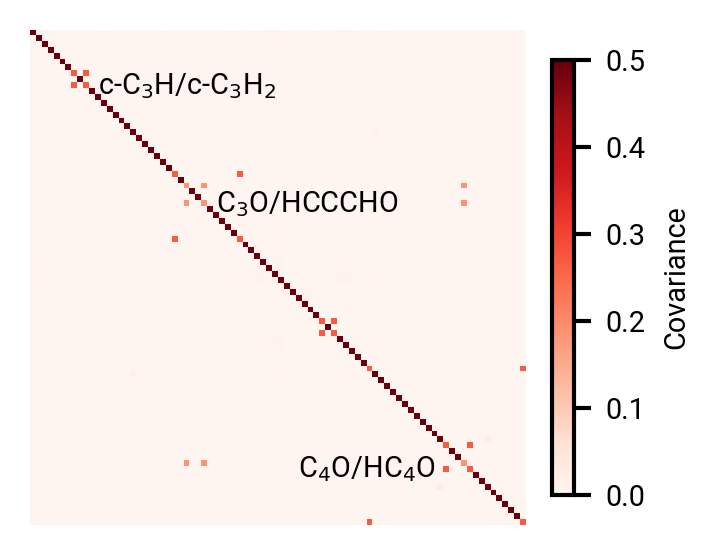

In [91]:
fig, ax = plt.subplots(figsize=(2.5,2.5))

hurr = ax.imshow(gp_tmc_cov, cmap="Reds", norm=Normalize(0., 0.5, clip=True))

cb = fig.colorbar(hurr, ax=ax, fraction=0.04)
cb.ax.set_ylabel("Covariance")
# ax.set(xticks=[], yticks=[])
# ax.set(xlim=[60,80],ylim=[60,80])
ax.text(11, 9, "c-C$_3$H/c-C$_3$H$_2$", fontsize="x-small", verticalalignment="center", color="k")
ax.text(31, 29, "C$_3$O/HCCCHO", fontsize="x-small", verticalalignment="center", color="k")
ax.text(45, 74, "C$_4$O/HC$_4$O", fontsize="x-small", verticalalignment="center", color="k")
ax.set(xticks=[], yticks=[])
for spine in ["left", "bottom"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
fig.savefig("../../reports/figures/gp_tmc1_covariance.pdf", dpi=600, transparent=True)

## UMAP viz

In [94]:
manifold_model = UMAP(n_neighbors=20, random_state=42, metric="cosine")

# train on context of cluster
manifold_model.fit(tmc1_embedding)

UMAP(n_neighbors=20, random_state=42)

In [95]:
# project TMC-1 molecules onto cluster manifold
# tmc1_rep = manifold_model.transform(tmc1_embedding)
all_rep = manifold_model.transform(all_pca)

In [110]:
from palettable.cartocolors.sequential import OrYel_5, Sunset_3

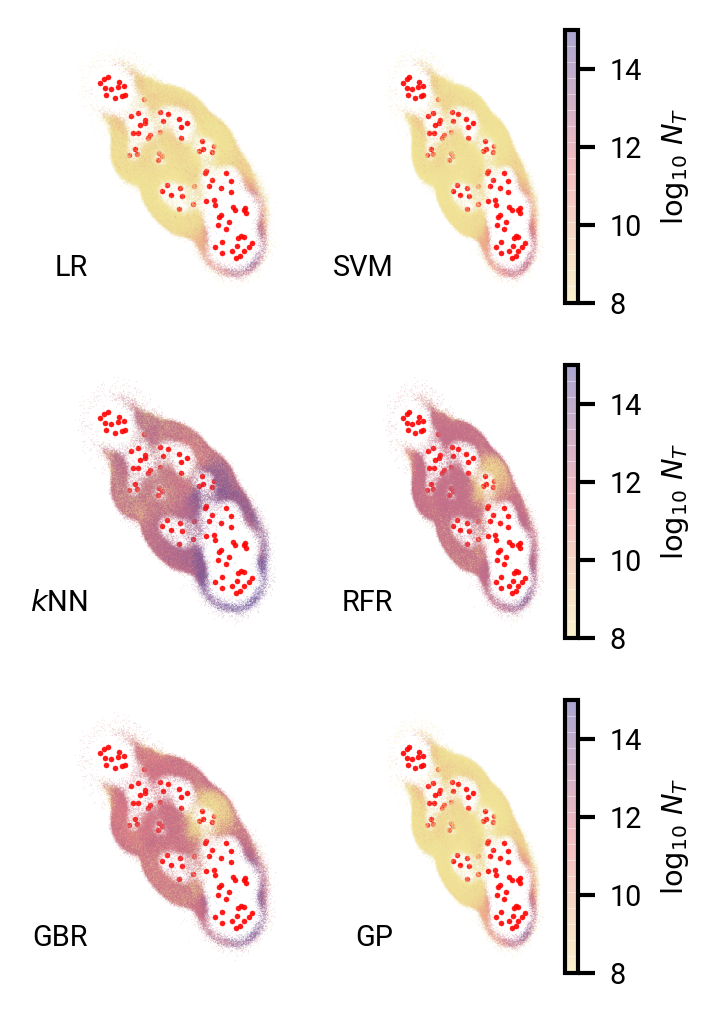

In [127]:
fig, axarray = plt.subplots(3, 2, figsize=(2.5, 3.5))

columns = [linear_cols, svm_cols, knn_cols, rfr_cols, gbr_cols, gp_cols]
names = ["LR", "SVM", "$k$NN", "RFR", "GBR", "GP"]

for index, (ax, name, column) in enumerate(zip(axarray.ravel(), names, columns)):
#     ax.set_facecolor('k')
    ax.scatter(manifold_model.embedding_[:,0], manifold_model.embedding_[:,1], s=1.5, lw=0.1, alpha=0.9, color="red")
    plot = ax.scatter(all_rep[:,0], all_rep[:,1], s=0.05, c=column, cmap=Sunset_3.get_mpl_colormap(), norm=Normalize(vmin=8., vmax=15), alpha=0.3, lw=0.)
#     ax.scatter(manifold_model.embedding_[dist_mask,0], manifold_model.embedding_[dist_mask,1], s=10., marker="x", c="w", alpha=0.4, lw=0.5)
    ax.text(0.1, 0.1, name, fontsize="x-small", horizontalalignment="right", transform=ax.transAxes)
    ax.set(xticks=[], yticks=[])
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    if index % 2 != 0:
        cb = fig.colorbar(plot, ax=ax)
        cb.set_label("$\log_{10}~N_T$")
fig.tight_layout()
fig.savefig("../../reports/figures/full_estimator_comparison.png", dpi=600, transparent=True)
# fig.savefig("../../reports/figures/full_estimator_comparison.svg", dpi=100)

In [91]:
import plotly.express as px
from plotly import graph_objs as go

In [105]:
names = data["smiles"][:]

In [106]:
fig = go.Figure(
    data=[go.Scattergl(
         x=all_rep[:,0],
         y=all_rep[:,1],
        mode="markers",
        opacity=0.4,
        text=names,
        marker={
            "color": gbr_cols,
            "colorscale": "Viridis",
            "colorbar": dict(thickness=20)
        },
        name="Gradient Boosting"
    ),
         go.Scattergl(
             x=manifold_model.embedding_[:,0],
            y=manifold_model.embedding_[:,1],
             mode="markers",
             opacity=0.9,
             text=tmc1_df["SMILES"],
             name="TMC-1"
         )
         ],
    layout={
        "paper_bgcolor": 'rgba(0,0,0,0)',
        "plot_bgcolor": 'rgba(0,0,0,0)',
        "xaxis": {"zeroline": False, "showline": False, "mirror": True},
        "yaxis": {"zeroline": False, "showline": False, "mirror": True}
    }
)

In [107]:
fig.write_html("interactive-all-predict.html", include_plotlyjs="cdn")